In [1]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
class LIFunc:
    """ Linearly interpolated function """
    def __init__ (self, x, y, kind='NP'):
        ## we assume x starts at zero and is linear
        assert(x[0]==0)
        self.x=x
        self.y=y
        self.dx=x[1]-x[0]
        self.N=len(x)
        self.kind=kind
                
    def __call__(self, atx):
        if self.kind=='lin':
            ii=(atx/self.dx).astype(int)
            eps=(atx-self.x[ii])/self.dx
            ## manually fix border case
            if ii[-1]==self.N-1:
                ii[-1]=self.N-2
                eps[-1]=0
            result=self.y[ii]+(self.y[ii+1]-self.y[ii])*eps
        elif self.kind=='NP':
            ii=(atx/self.dx+0.5).astype(int)
            result=self.y[ii]
        elif self.kind=='SNP':
            ii=(atx/self.dx+0.5).astype(int)
            result=self.y[ii]**2
        else:
            assert(False)

        return result

    def first_der(self,atx):
        ## returns array size(atx) x size(self.x) containg df(atx)/dy_i
        toret=np.zeros((len(atx),len(self.x)))
        if self.kind=='lin':
            ii=(atx/self.dx).astype(int)
            eps=(atx-self.x[ii])/self.dx
            if ii[-1]==self.N-1:
                ii[-1]=self.N-2
                eps[-1]=0

            for a,b in enumerate(ii):
                    toret[a,b]=(1-eps[b])
                    toret[a,b+1]=eps[b]                       
        elif self.kind=='NP':
            ii=(atx/self.dx+0.5).astype(int)
            for a,b in enumerate(ii):
                toret[a,b]=1.0        
        elif self.kind=='SNP':
            ii=(atx/self.dx+0.5).astype(int)
            for a,b in enumerate(ii):
                toret[a,b]=2*self.y[b]        
        else:
            assert(False)
        return toret
    
    def update_y(self,newy):
            self.y=newy

class FitLIFunc:
    def __init__ (self, datax, datay, erry, lif, diagmult=0.0,fdreg=0, sdreg=0):
        self.datax=datax
        self.datay=datay
        self.sigma=erry
        self.isigma2=1/erry**2
        self.lif=lif
        self.diagmult=diagmult
        N=self.lif.N
        if (fdreg>0):
            fdmat=np.zeros((N,N))
            for i in range(N-1):
                l=np.zeros(N)
                l[i+1]=1
                l[i]=-1
                fdmat+=np.outer(l,l)
            fdmat*=fdreg
            self.fdmat=fdmat
        else:
            self.fdmat=None
        if (sdreg>0):
            sdmat=np.zeros((N,N))
            for i in range(1,N-1):
                l=np.zeros(N)
                l[i+1]=1
                l[i]=-2
                l[i-1]=1
                sdmat+=np.outer(l,l)
            sdmat*=sdreg
            self.sdmat=sdmat
        else:
            self.sdmat=0
        
        
        
    def chi2(self, modely=None):
        if modely is not None:
            self.lif.update_y(modely)
        diff = self.datay-self.lif(self.datax)
        chi2 = np.sum(diff**2*self.isigma2)
        return chi2

    def loglike(self, modely=None):
        return -self.chi2(modely)
        
        
    def NR_step(self):
        """ Performs one NR-step"""
        diff = self.datay-self.lif(self.datax)
        theory_der=self.lif.first_der(self.datax)
        N=self.lif.N
        FD=np.zeros(N)
        SD=np.zeros((N,N))
        for i in range(N):
            FD[i] = -np.sum(diff*self.isigma2*theory_der[:,i]) 
            for j in range(i,N):
                SD[i,j]=np.sum(self.isigma2*theory_der[:,i]*theory_der[:,j])
                SD[j,i]=SD[i,j]
        if self.diagmult>0:
            SD[np.diag_indices(N)]*=(1+self.diagmult)
        SD[np.diag_indices(N)]+=1e-10
        if (self.fdmat is not None):
            SD+=self.fdmat
        if (self.sdmat is not None):
            SD+=self.sdmat
        step = -np.dot(la.inv(SD),FD)
        self.lif.update_y(self.lif.y+step)
        
    def NR_converge(self):
        chi2=self.chi2()
        print (chi2)
        while True:            
            cury=self.lif.y
            self.NR_step()
            nchi2=self.chi2()
            #print (nchi2)
            if (nchi2>chi2):
                print ("Moving away from min")
                self.lif.update_y(cury)
                break
            else:
                if (chi2-nchi2)<0.1:
                    print ("Converged")
                    break
            chi2=nchi2
        print ("Final chi2=",chi2)
        return
        
        
        
        

In [3]:
def TrialFit (x,y,noise, maxx,fitN, kind='NP', diagmult=0.0, fdreg=0, sdreg=0):
    Nx=len(x)
    fitx=np.linspace(0,5.,fitN)
    itf=LIFunc(fitx,np.zeros(fitN) + (1 if kind=='SNP' else 0),kind=kind)
    a=FitLIFunc(x,y,noise,itf,diagmult=diagmult,fdreg=fdreg,sdreg=sdreg)
    a.NR_converge()
    #plt.plot(x,a.lif(x))
    xp=np.linspace(0,maxx,fitN*4)
    plt.plot(xp,a.lif(xp))
    return a


988.015524553595
Converged
Final chi2= 91.31472083259752
988.015524553595
Moving away from min
Final chi2= 84.21021188969564
199.50283247202123
Moving away from min
Final chi2= 75.68495147389173


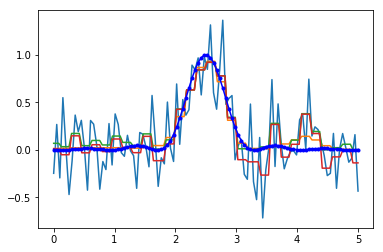

In [4]:
Nx=100
x=np.linspace(0,5,Nx)
y=np.sin(4*(x-2.5))**2/(4*(x-2.5))**2
noise=0.3
ywnoise=y+np.random.normal(0,noise,Nx)
plt.plot(x,ywnoise)
a=TrialFit(x,ywnoise,noise,5,30,fdreg=1e3,sdreg=1e3,kind='SNP')
#print (a.lif.y)
a=TrialFit(x,ywnoise,noise,5,30,kind='SNP')
a=TrialFit(x,ywnoise,noise,5,30,kind='NP')
plt.plot(x,y,'b.-')

81041.51334145259
Converged
Final chi2= 0.9278782652365987
8726.360156411667
Converged
Final chi2= 0.021890710444155262
8726.360156411667
Converged
Final chi2= 8.594613742884607e-25


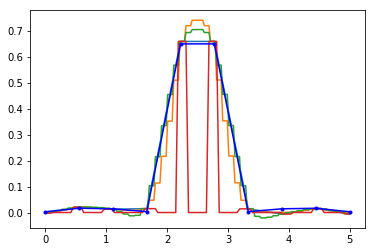

In [5]:
Nx=10
x=np.linspace(0,5,Nx)
y=np.sin(4*(x-2.5))**2/(4*(x-2.5))**2
noise=0.01
ywnoise=y+np.random.normal(0,noise,Nx)
plt.plot(x,ywnoise)
a=TrialFit(x,ywnoise,noise,5,50,kind='SNP',fdreg=1e3,sdreg=1e3)
a=TrialFit(x,ywnoise,noise,5,50,kind='NP',fdreg=1e3,sdreg=1e3)
#print (a.lif.y)
a=TrialFit(x,ywnoise,noise,5,30,kind='NP',fdreg=0.0)
plt.plot(x,y,'b.-')